# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [2]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt



### Paso 1: Descargar y Parsear HTML

In [3]:
url = 'https://quotes.toscrape.com/'
response = requests.get(url)
soup = BeautifulSoup(response.content)

soup



<!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8"/>
<title>Quotes to Scrape</title>
<link href="/static/bootstrap.min.css" rel="stylesheet"/>
<link href="/static/main.css" rel="stylesheet"/>
</head>
<body>
<div class="container">
<div class="row header-box">
<div class="col-md-8">
<h1>
<a href="/" style="text-decoration: none">Quotes to Scrape</a>
</h1>
</div>
<div class="col-md-4">
<p>
<a href="/login">Login</a>
</p>
</div>
</div>
<div class="row">
<div class="col-md-8">
<div class="quote" itemscope="" itemtype="http://schema.org/CreativeWork">
<span class="text" itemprop="text">“The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.”</span>
<span>by <small class="author" itemprop="author">Albert Einstein</small>
<a href="/author/Albert-Einstein">(about)</a>
</span>
<div class="tags">
            Tags:
            <meta class="keywords" content="change,deep-thoughts,thinking,world" itemprop="keywords"/>
<a class="t

### Paso 2: Obtener los datos de interes

In [35]:
phrases = soup.find_all('div', class_='quote') #Te devuelve todos los tags, lo recorremos con for

list_of_phrases = []

for sentence in phrases:
    famous_phrase = sentence.find('span',class_='text').text.replace('“','').replace('”','') #Limpiamos un poco y obtenemos el string sin comillas.
    by = sentence.find('small',class_='author').text
    tags = sentence.find('a', class_='tag').text
    list_of_phrases.append({"Sentence": famous_phrase,
                         "By":by,
                         "Tags":tags})


list_of_phrases

 
    



[{'Sentence': 'The world as we have created it is a process of our thinking. It cannot be changed without changing our thinking.',
  'By': 'Albert Einstein',
  'Tags': 'change'},
 {'Sentence': 'It is our choices, Harry, that show what we truly are, far more than our abilities.',
  'By': 'J.K. Rowling',
  'Tags': 'abilities'},
 {'Sentence': 'There are only two ways to live your life. One is as though nothing is a miracle. The other is as though everything is a miracle.',
  'By': 'Albert Einstein',
  'Tags': 'inspirational'},
 {'Sentence': 'The person, be it gentleman or lady, who has not pleasure in a good novel, must be intolerably stupid.',
  'By': 'Jane Austen',
  'Tags': 'aliteracy'},
 {'Sentence': "Imperfection is beauty, madness is genius and it's better to be absolutely ridiculous than absolutely boring.",
  'By': 'Marilyn Monroe',
  'Tags': 'be-yourself'},
 {'Sentence': 'Try not to become a man of success. Rather become a man of value.',
  'By': 'Albert Einstein',
  'Tags': 'adu

### Paso 3: Generar DF y Limpiar DataSet

In [36]:
df = pd.DataFrame(list_of_phrases)
df["Initial"] = df["By"].apply(lambda apellido: apellido.split()[0][:2])
df["Tags"] = df["Tags"].apply(lambda string: string.replace("-",", ").title())
df=df[["Sentence","By","Initial","Tags"]]
df
#Limpiamos un poco el DF y lo ordenamos.

,Sentence,By,Initial,Tags
0,The world as we have created it is a process o...,Albert Einstein,Al,Change
1,"It is our choices, Harry, that show what we tr...",J.K. Rowling,J.,Abilities
2,There are only two ways to live your life. One...,Albert Einstein,Al,Inspirational
3,"The person, be it gentleman or lady, who has n...",Jane Austen,Ja,Aliteracy
4,"Imperfection is beauty, madness is genius and ...",Marilyn Monroe,Ma,"Be, Yourself"
5,Try not to become a man of success. Rather bec...,Albert Einstein,Al,Adulthood
6,It is better to be hated for what you are than...,André Gide,An,Life
7,"I have not failed. I've just found 10,000 ways...",Thomas A. Edison,Th,Edison
8,A woman is like a tea bag; you never know how ...,Eleanor Roosevelt,El,"Misattributed, Eleanor, Roosevelt"
9,"A day without sunshine is like, you know, night.",Steve Martin,St,Humor


### Paso 4: Generar y Almacenar en SQLite

In [37]:
conn = sqlite3.connect("famous quotes") #Creamos la bd sino existe o la abre si existe.

df.to_sql("quotes",conn, if_exists="replace",index=False) #Guardamos el df en la tabla "quotes"
#Si existe la remplazamos con if_exists...
#Evitamos que se almacene los indices de pandas con index...

cursor = conn.cursor() #Nos permite ejecutar consultas manuales

cursor.execute("SELECT COUNT(*) FROM quotes") #Ejecutamos la consulta
print("Rows inserted:", cursor.fetchone()[0])


conn.commit() #Guardamos
conn.close() #Cerramos conexión

Rows inserted: 10


### Paso 5: Visualización

/tmp/ipykernel_2773/1568020673.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_group, x="Initial",y="Length", ax=axs[1], palette="Set2")


Text(0, 0.5, 'Sentence Length')

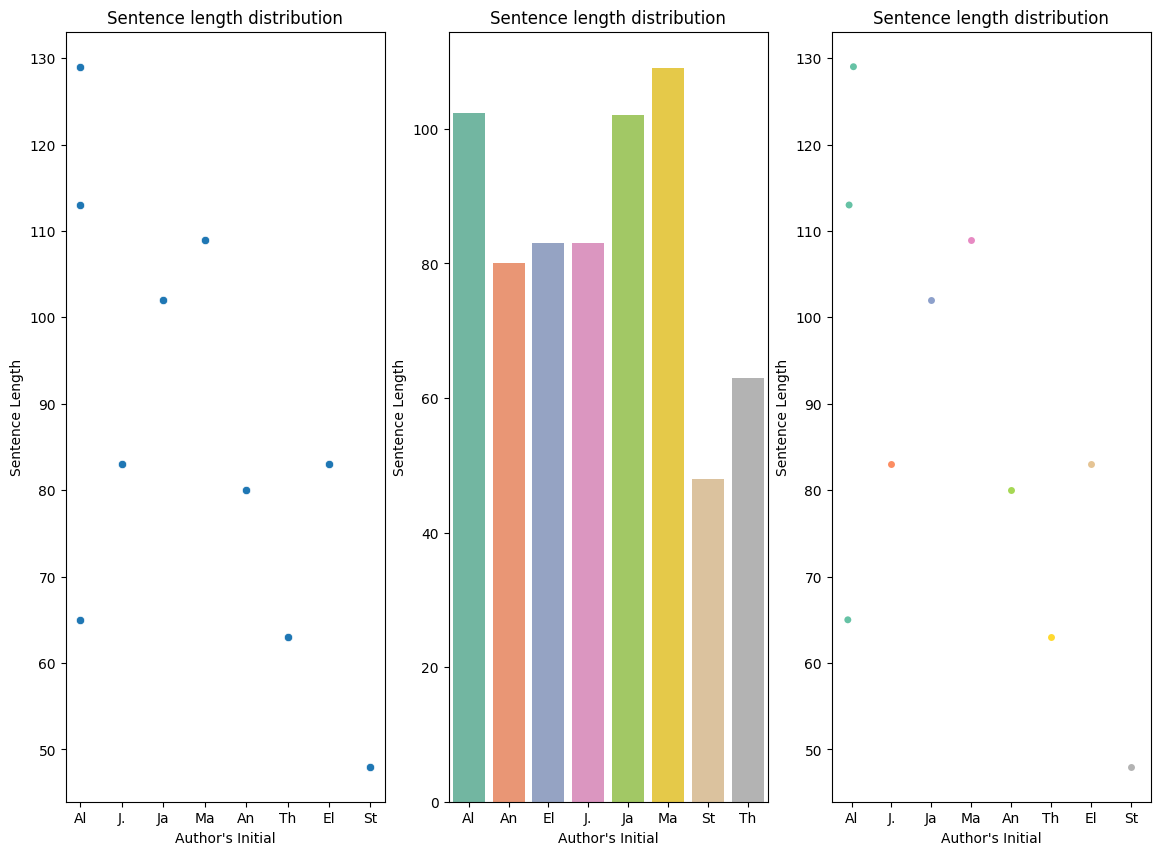

<Figure size 1400x600 with 0 Axes>

In [43]:
fig, axs = plt.subplots(1,3, figsize=(14,10))

authors = df["Initial"]
df["Length"] = df["Sentence"].apply(len)
phrases = df["Length"]
plt.figure(figsize=(14, 6))
sns.scatterplot(x=authors,y=phrases,ax=axs[0])
axs[0].set_title("Sentence length distribution")
axs[0].set_xlabel("Author's Initial")
axs[0].set_ylabel("Sentence Length")

df_group = df.groupby("Initial")["Length"].mean().reset_index()
df_group

sns.barplot(data=df_group, x="Initial",y="Length", ax=axs[1], palette="Set2")
axs[1].set_title("Sentence length distribution")
axs[1].set_xlabel("Author's Initial")
axs[1].set_ylabel("Sentence Length")

sns.stripplot(data=df, x="Initial", y="Length", ax=axs[2], palette="Set2",hue="Initial")
axs[2].set_title("Sentence length distribution")
axs[2].set_xlabel("Author's Initial")
axs[2].set_ylabel("Sentence Length")



### Conclusiones

Aunque la parte de visualización no era obligatoria, decidí incluirla para seguir practicando cómo mostrar varios gráficos juntos y comparar datos de forma visual. Me ayudó a entender mejor cómo varía la longitud de las frases según los autores, y también a probar distintos tipos de gráficos. En el proceso, aprendí la diferencia entre scatterplot y stripplot, aunque en este caso se ven prácticamente iguales, descubrí que eso pasa porque estoy usando una variable categórica en el eje X (los autores), lo que hace que ambos gráficos terminen mostrando puntos agrupados de forma similar. Me pareció interesante ver cómo cada gráfico tiene su lógica interna, y cómo elegir el adecuado depende del tipo de datos que estás trabajando.